In [1]:
# First importing our libraries
import pandas
import geopandas
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import contextily as ctx

In [2]:
columns_to_keep = ['TotalValue','geometry','LandValue','YearBuilt']

In [ ]:
# Create an array of all years of assessor data using for loop
parcel_dataframes = []

for year in range(2006,2022):
    parcel_data_filepath = "Assessor_Parcels_Data_" + str(year) + "_TRA.geojson"
    parcel_dataframe_raw = geopandas.read_file(parcel_data_filepath)
    parcel_dataframe = parcel_dataframe_raw[columns_to_keep].copy()
    parcel_dataframe['Year'] = year
    parcel_dataframes.append(parcel_dataframe)
    parcel_dataframe['TotalValue'] = parcel_dataframe['TotalValue'].div(1000)

print(parcel_dataframes[0].info())

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1095 entries, 0 to 1094
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   TotalValue  1095 non-null   float64 
 1   geometry    1095 non-null   geometry
 2   LandValue   1095 non-null   float64 
 3   YearBuilt   1095 non-null   int64   
 4   Year        1095 non-null   int64   
dtypes: float64(2), geometry(1), int64(2)
memory usage: 42.9 KB
None


In [ ]:
print(parcel_dataframes[5].sample(5))

     TotalValue                                           geometry  LandValue  \
0       626.659  POLYGON Z ((-118.23615 34.06662 0.00000, -118....   442111.0   
796     286.898  POLYGON Z ((-118.24457 34.06356 0.00000, -118....    41125.0   
756    1423.000  POLYGON Z ((-118.23825 34.06108 0.00000, -118....   975900.0   
714      71.335  POLYGON Z ((-118.23859 34.06670 0.00000, -118....    48202.0   
462     115.740  POLYGON Z ((-118.24222 34.06301 0.00000, -118....    26774.0   

     YearBuilt  Year  
0         1964  2011  
796       1979  2011  
756       2007  2011  
714       1940  2011  
462       1972  2011  


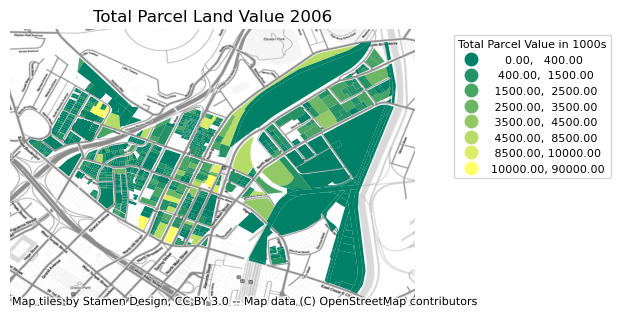

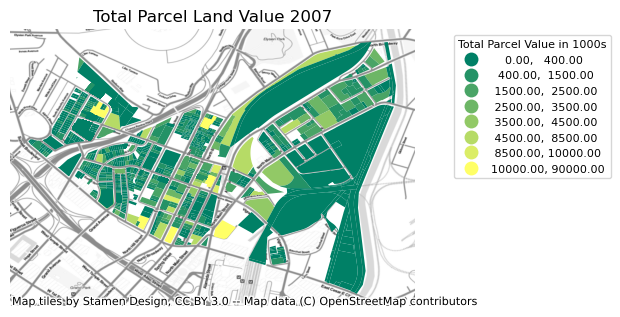

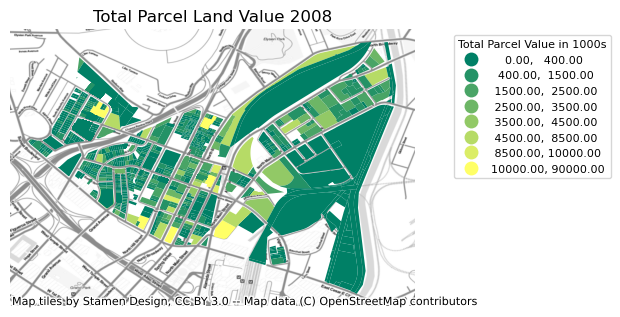

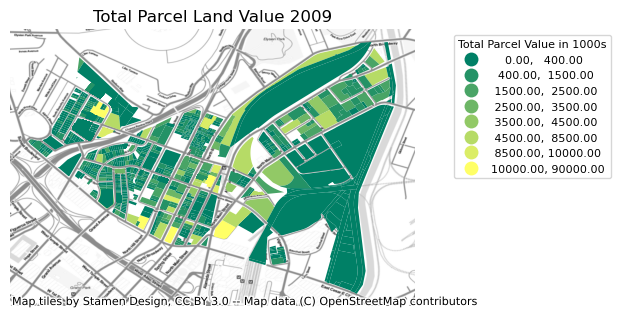

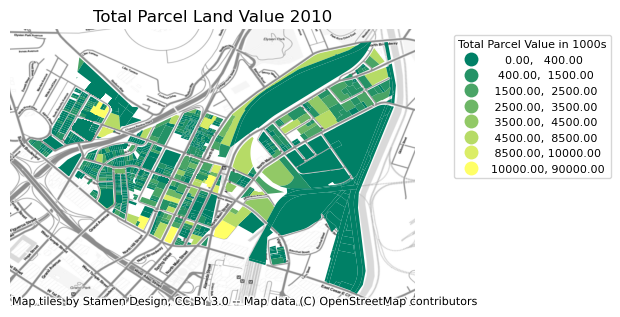

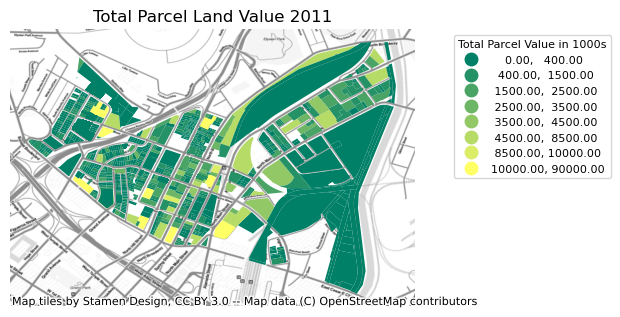

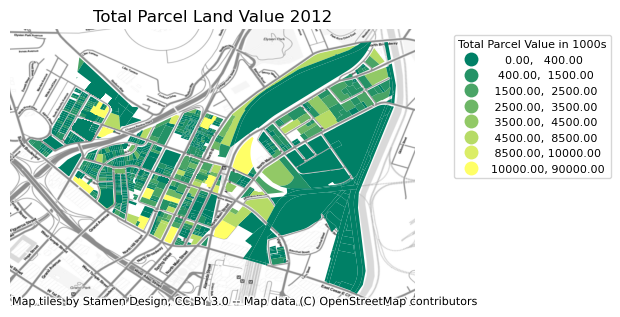

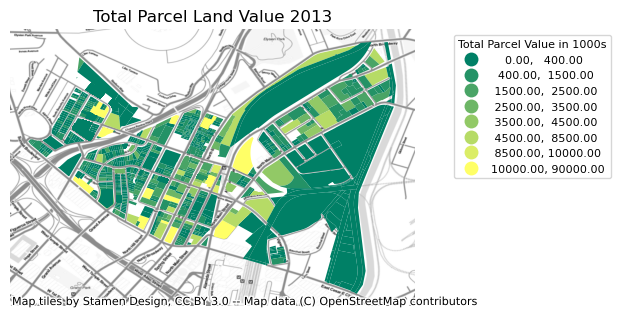

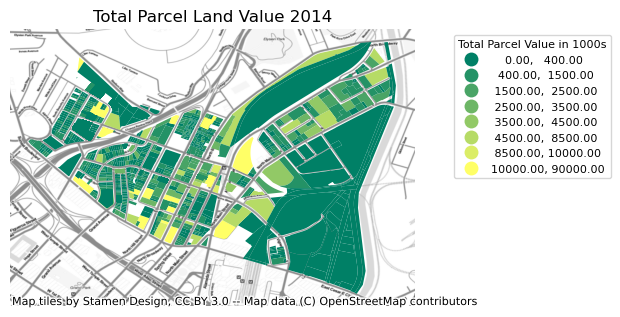

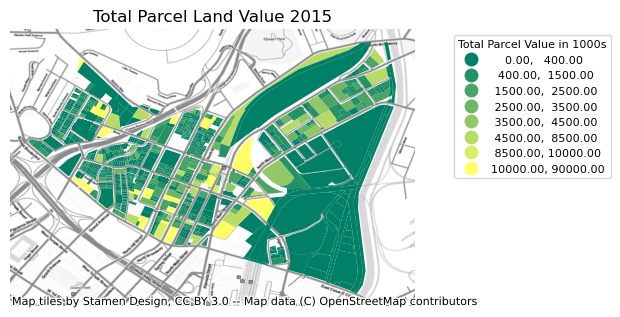

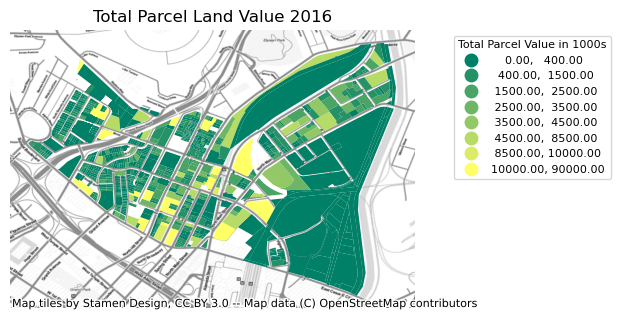

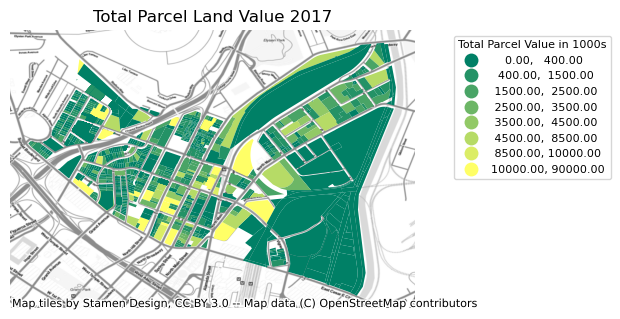

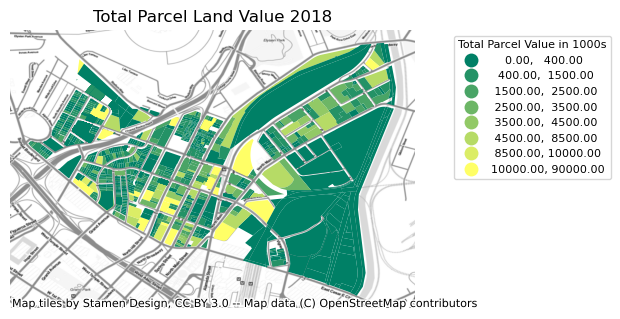

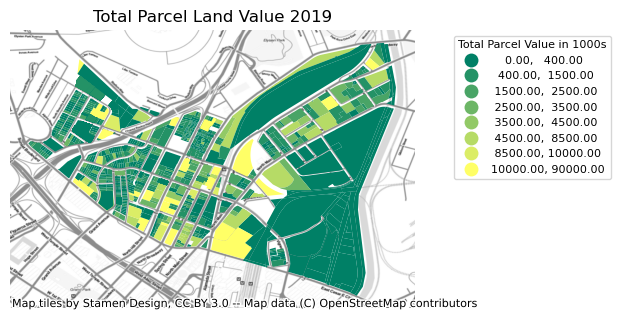

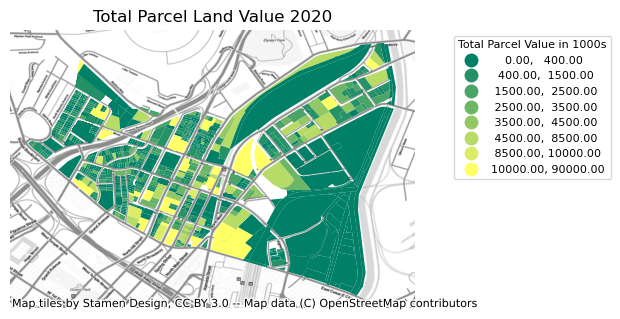

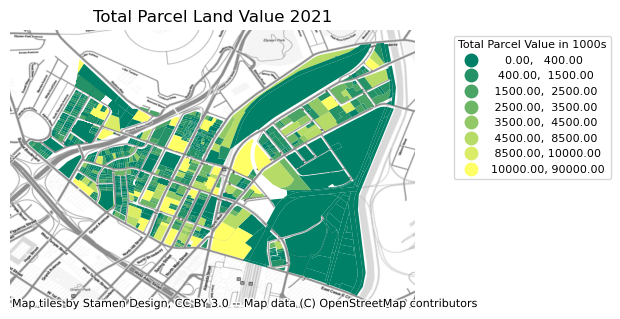

In [11]:
# Now create for loop to print out all maps for Total Value

for parcel_dataframe in parcel_dataframes:
    fig, ax = plt.subplots(figsize=(7,7))
    parcel_dataframe.plot(ax=ax,
                          column='TotalValue', cmap='summer',
                          legend=True,
                       scheme='userdefined',
                      legend_kwds={'title': "Total Parcel Value in 1000s", 'prop': {'size': 8}, 'title_fontsize': 8, 'bbox_to_anchor': (1.5, 1)},
                  classification_kwds=dict(bins=[400,1500,2500,3500,4500,8500,10000,90000]))
    ax.set_title('Total Parcel Land Value ' +str(parcel_dataframe['Year'][0] ))
    ax.axis('off')
    
    ctx.add_basemap(ax,source=ctx.providers.Stamen.TonerLite,crs=4326)
    plt.tight_layout()
   # plt.savefig('totalparcelvalue' + str(parcel_dataframe['Year'][1]) + '.jpg', dpi=199)
    

In [6]:
import imageio.v2 as imageio
# unitmapsR = ['totalparcelvalue2006.jpg', 'totalparcelvalue2010.jpg', 'totalparcelvalue2014.jpg', 'totalparcelvalue2018.jpg', 'totalparcelvalue2021.jpg']

# images = []
# for unitmap in unitmapsR:
    # images.append(imageio.imread(unitmap))
# imageio.mimsave('Totalparcelvalue.gif',images,duration=1.0)

In [ ]:
import numpy as np
import pandas as pd
import geopandas as gpd
import urllib.parse
import requests
import matplotlib.pyplot as plt
import contextily as ctx

def query_arcgis_feature_server(url_feature_server=''):
    '''
    This function downloads all of the features available on a given ArcGIS 
    feature server. The function is written to bypass the limitations imposed
    by the online service, such as only returning up to 1,000 or 2,000 featues
    at a time.

    Parameters
    ----------
    url_feature_server : string
        Sting containing the URL of the service API you want to query. It should 
        end in a forward slash and look something like this:
        'https://services.arcgis.com/P3ePLMYs2RVChkJx/arcgis/rest/services/USA_Counties/FeatureServer/0/'

    Returns
    -------
    geodata_final : gpd.GeoDataFrame
        This is a GeoDataFrame that contains all of the features from the 
        Feature Server. After calling this function, the `geodata_final` object 
        can be used to store the data on disk in several different formats 
        including, but not limited to, Shapefile (.shp), GeoJSON (.geojson), 
        GeoPackage (.gpkg), or PostGIS.
        See https://geopandas.org/en/stable/docs/user_guide/io.html#writing-spatial-data
        for more details.

    '''
    if url_feature_server == '':
        geodata_final = gpd.GeoDataFrame()
        return geodata_final

    # Fixing last character in case the URL provided didn't end in a 
    # forward slash
    if url_feature_server[-1] != '/':
        url_feature_server = url_feature_server + '/'
    
    # Getting the layer definitions. This contains important info such as the 
    # name of the column used as feature_ids/object_ids, among other things.
    layer_def = requests.get(url_feature_server + '?f=pjson').json()
    
    # The `objectIdField` is the column name used for the 
    # feature_ids/object_ids
    # fid_colname = layer_def['objectIdField']
    fid_colname = 'OBJECTID'

    
    # The `maxRecordCount` tells us the maximum number of records this REST 
    # API service can return at once. The code below is written such that we 
    # perform multiple calls to the API, each one being short enough never to 
    # go beyond this limit.
    record_count_max = layer_def['maxRecordCount']
    
    # Part of the URL that specifically requests only the object IDs
    url_query_get_ids = (f'query?f=geojson&returnIdsOnly=true'
                         f'&where={fid_colname}+is+not+null')
    
    url_comb = url_feature_server + url_query_get_ids
    
    # Getting all the object IDs
    service_request = requests.get(url_comb)
    # print(service_request.json())
    all_objectids = np.sort(service_request.json()['objectIds'])
    
    # This variable will store all the parts of the multiple queries. These 
    # parts will, at the end, be concatenated into one large GeoDataFrame.
    geodata_parts = []
    
    # This part of the query is fixed and never actually changes
    url_query_fixed = ('query?f=geojson&outFields=*&where=')
    
    # Identifying the largest query size allowed per request. This will dictate 
    # how many queries will need to be made. We start the search at
    # the max record count, but that generates errors sometimes - the query 
    # might time out because it's too big. If the test query times out, we try 
    # shrink the query size until the test query goes through without 
    # generating a time-out error.
    block_size = min(record_count_max, len(all_objectids))
    worked = False
    while not worked:
        # Moving the "cursors" to their appropriate locations
        id_start = all_objectids[0]
        id_end = all_objectids[block_size-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        url_get = requests.get(url_comb)
        
        if 'error' in url_get.json():
            block_size = int(block_size/2)+1
        else:
            geodata_part = gpd.read_file(url_get.text)
            
            geodata_parts.append(geodata_part.copy())
            worked = True
    
    # Performing the actual query to the API multiple times. This skips the 
    # first few rows/features in the data because those rows were already 
    # captured in the query performed in the code chunk above.
    for i in range(block_size, len(all_objectids), block_size):
        # Moving the "cursors" to their appropriate locations and finding the 
        # limits of each block
        sub_list = all_objectids[i:i + block_size]
        id_start = sub_list[0]
        id_end = sub_list[-1]

        readable_query_string = (f'{fid_colname}>={id_start} '
                                 f'and {fid_colname}<={id_end}')
        
        # Encoding from readable text to URL
        url_query_variable =  urllib.parse.quote(readable_query_string)
    
        # Constructing the full request URL
        url_comb = url_feature_server + url_query_fixed + url_query_variable
        
        # Actually performing the query and storing its results in a 
        # GeoDataFrame
        geodata_part =  (gpd.read_file(url_comb, 
                                       driver='GeoJSON'))
        
        # Appending the result to `geodata_parts`
        if geodata_part.shape[0] > 0:
            geodata_parts.append(geodata_part)

    # Concatenating all of the query parts into one large GeoDataFrame
    geodata_final = (pd.concat(geodata_parts, 
                               ignore_index=True)
                     .sort_values(by=fid_colname)
                     .reset_index(drop=True))
    
    # Checking if any object ID is missing
    ids_queried = set(geodata_final[fid_colname])
    for i,this_id in enumerate(all_objectids):
        if this_id not in ids_queried:
            print('WARNING! The following ObjectID is missing from the final '
                  f'GeoDataFrame: ObjectID={this_id}')
            pass
    
    # Checking if any object ID is included twice
    geodata_temp = geodata_final[[fid_colname]].copy()
    geodata_temp['temp'] = 1
    geodata_temp = (geodata_temp
                    .groupby(fid_colname)
                    .agg({'temp':'sum'})
                    .reset_index())
    geodata_temp = geodata_temp.loc[geodata_temp['temp']>1].copy()
    for i,this_id in enumerate(geodata_temp[fid_colname].values):
        n_times = geodata_temp['temp'].values[i]
        print('WARNING! The following ObjectID is included multiple times in'
              f'the final GeoDataFrame: ObjectID={this_id}\tOccurrences={n_times}')
    
    return geodata_final

In [ ]:
# define your arc server url endpoint
url='https://egispais.gis.lacounty.gov/pais/rest/services/PAIS/pais_sales_parcels/MapServer/0/'

In [ ]:
# make the function call and put results in a variable 'parcel'
parcel = query_arcgis_feature_server(url)

In [ ]:
chinatown_parcels = gpd.read_file('LA_County_Parcels_Feature_Clip.zip')

In [ ]:
columns_to_use = chinatown_parcels.columns.difference(parcel.columns).union(['AIN'])
columns_to_use

In [12]:
recently_sold_df = parcel.merge(chinatown_parcels[columns_to_use], on='AIN')

NameError: name 'parcel' is not defined

In [13]:
desired_columns = ['AIN','SitusFullA','LAT_LON','YearBuilt1','USETYPE','geometry']
recently_sold_df_clipped = recently_sold_df[desired_columns].copy()
recently_sold_df_clipped.sample(5)

NameError: name 'recently_sold_df' is not defined

In [14]:
recently_sold_df_clipped['USETYPE'] = recently_sold_df_clipped['USETYPE'].replace(['C/I', 'CND', 'OTH', 'R-I', 'SFR', 'VAC'], ['Commercial / Industrial', 'Condominium', 'Other', 'Multiple Family Residence', 'Single Family Residence', 'Vacant Land'])


NameError: name 'recently_sold_df_clipped' is not defined

In [ ]:
fig, ax = plt.subplots(figsize=(12,10))
# Plot Chinatown neighborhood boundaries
chinatown_neighborhood = gpd.read_file("https://services5.arcgis.com/7nsPwEMP38bSkCjy/arcgis/rest/services/LA_Times_Neighborhoods/FeatureServer/0/query?where=name%20%3D%20'CHINATOWN'&outFields=*&outSR=4326&f=geojson")
chinatown_neighborhood.plot(ax=ax,facecolor='none',edgecolor='#252525',linewidth=2)
ax.axis('off')
ctx.add_basemap(ax, source=ctx.providers.Stamen.TonerLite,crs=4326,alpha=0.2)
# Plot existing market-rate developments
recently_sold_df_clipped.plot(ax=ax,
                              column = 'USETYPE',
                              cmap='tab20b',
                              legend=True,
         legend_kwds={'loc':'lower left'})
#Add title
ax.set_title('Recently Sold Parcels by Use Type')

fig.savefig('recentlysoldparcels.pdf')